# proj_01 — Supply Chain: On-Time Delivery & Cost Modeling
This notebook aligns with *Machine Learning with Python (Course 1)*. It demonstrates supervised learning (classification + regression), basic EDA, proper validation, and model evaluation.

**Objectives**
- Generate synthetic shipment data (carriers, lanes, distance, weight, service level)
- Predict **OnTimeDelivery** (classification)
- Predict **ShipmentCost** (regression)
- Save trained artifacts for later use in a Streamlit app

In [ ]:

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import joblib
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# # Create assets dir if running outside pre-built environment
# ASSETS = os.path.join(os.getcwd(), "proj_01_assets")
# os.makedirs(ASSETS, exist_ok=True)



In [46]:

# --- Standardized paths for repo-friendly saves ---
from pathlib import Path
import os

# Resolve project root whether running from repo root or notebooks/
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

DATA = ROOT / "proj_01" / "data" if (ROOT / "proj_01").exists() else ROOT / "data"
MODELS = ROOT / "proj_01" / "models" if (ROOT / "proj_01").exists() else ROOT / "models"

DATA.mkdir(parents=True, exist_ok=True)
MODELS.mkdir(parents=True, exist_ok=True)

print(f"Saving CSVs to: {DATA}")
print(f"Saving models to: {MODELS}")


Saving CSVs to: C:\Users\dsurr\ibm_certs\SupplyChainHealthCare\proj_01\data
Saving models to: C:\Users\dsurr\ibm_certs\SupplyChainHealthCare\proj_01\models


In [47]:

# Matplotlib settings (default colors, single-plot rule honored in guidance)
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True


## 1) Generate Synthetic Shipment Data

In [48]:

# Synthetic data generation
n = 10000
origins = ["DAL", "HOU", "ATL", "CHI", "LAX", "SEA", "DEN", "PHX"]
destinations = ["NYC", "BOS", "MIA", "PHL", "SFO", "SJC", "MSP", "DTW"]
carriers = ["AlphaTrans", "BetaLogix", "GammaFreight", "DeltaHaul"]
service_levels = ["Standard", "Expedited", "Economy"]

def random_choice(arr, size):
    return np.random.choice(arr, size=size)

origin = random_choice(origins, n)
destination = random_choice(destinations, n)
carrier = random_choice(carriers, n)
service = random_choice(service_levels, n)

# Derived features
distance = np.random.gamma(shape=5.0, scale=120.0, size=n)  # ~ 0-3000 miles, skewed
weight = np.abs(np.random.normal(loc=1200, scale=500, size=n)) + 50  # lbs
stops = np.random.choice([1,2,3], size=n, p=[0.7, 0.25, 0.05])

# Base cost model (latent function + noise)
base_rate_per_mile = {"Standard": 1.3, "Expedited": 1.9, "Economy": 1.0}
carrier_factor = {"AlphaTrans": 1.00, "BetaLogix": 1.07, "GammaFreight": 0.95, "DeltaHaul": 1.03}

cost = []
for i in range(n):
    pm = base_rate_per_mile[service[i]] * carrier_factor[carrier[i]]
    c = pm * distance[i] * (1 + 0.0004*weight[i]) + 25*stops[i]
    c += np.random.normal(0, 80)  # noise
    cost.append(max(50, c))

# On-time delivery probability (latent reliability model)
lane_risk = {}
for o in origins:
    for d in destinations:
        # some lanes tougher (randomly assign)
        lane_risk[(o,d)] = np.random.uniform(0.05, 0.25)

carrier_reliability = {"AlphaTrans": 0.90, "BetaLogix": 0.82, "GammaFreight": 0.88, "DeltaHaul": 0.85}
service_bonus = {"Standard": 0.00, "Expedited": 0.07, "Economy": -0.04}

p_ontime = []
for i in range(n):
    base = 0.7 + service_bonus[service[i]] + (carrier_reliability[carrier[i]] - 0.85)
    base -= lane_risk[(origin[i], destination[i])]  # higher risk -> lower on-time
    base -= 0.00007*distance[i]  # longer distance slightly riskier
    base -= 0.02*(stops[i]-1)    # more stops -> riskier
    base = np.clip(base, 0.1, 0.95)
    p_ontime.append(base)

on_time = (np.random.rand(n) < np.array(p_ontime)).astype(int)

df = pd.DataFrame({
    "Origin": origin,
    "Destination": destination,
    "Carrier": carrier,
    "ServiceLevel": service,
    "Distance": distance.round(1),
    "Weight": weight.round(1),
    "Stops": stops,
    "ShipmentCost": np.round(cost, 2),
    "OnTimeDelivery": on_time
})

df.to_csv(DATA / "supply_chain_shipments.csv", index=False)
df.head()


,Origin,Destination,Carrier,ServiceLevel,Distance,Weight,Stops,ShipmentCost,OnTimeDelivery
0,DEN,MIA,GammaFreight,Expedited,402.2,1031.1,2,1004.43,1
1,CHI,DTW,DeltaHaul,Standard,1063.6,837.6,1,1903.25,0
2,LAX,MSP,DeltaHaul,Standard,683.6,1825.7,1,1601.35,0
3,DEN,DTW,BetaLogix,Expedited,551.8,1692.1,1,1994.60,1
4,ATL,DTW,AlphaTrans,Economy,626.1,731.0,1,751.54,0


## 2) Quick EDA

In [49]:

df.describe(include='all').T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Origin,10000,8,LAX,1271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,10000,8,BOS,1303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Carrier,10000,4,BetaLogix,2534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ServiceLevel,10000,3,Standard,3344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,10000.0,NaN,NaN,NaN,597.01145,269.047878,47.3,398.875,556.9,750.6,2241.5
Weight,10000.0,NaN,NaN,NaN,1261.364,495.794054,50.6,923.475,1257.2,1591.425,3138.1
Stops,10000.0,NaN,NaN,NaN,1.3652,0.584862,1.0,1.0,1.0,2.0,3.0
ShipmentCost,10000.0,NaN,NaN,NaN,1306.907426,714.36681,50.0,796.4575,1152.445,1666.8875,7477.61
OnTimeDelivery,10000.0,NaN,NaN,NaN,0.5211,0.49958,0.0,0.0,1.0,1.0,1.0


In [50]:

# Class balance for OnTimeDelivery
df['OnTimeDelivery'].value_counts(normalize=True)


OnTimeDelivery
1    0.5211
0    0.4789
Name: proportion, dtype: float64

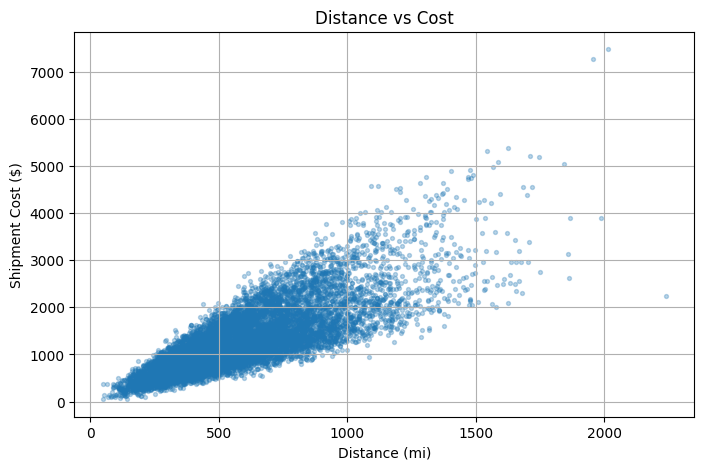

In [51]:

# Simple visual: distance vs cost
plt.figure()
plt.scatter(df['Distance'], df['ShipmentCost'], s=8, alpha=0.3)
plt.xlabel("Distance (mi)"); plt.ylabel("Shipment Cost ($)"); plt.title("Distance vs Cost")
plt.show()


## 3) Classification: Predict On-Time Delivery

In [52]:

X_cls = df.drop(columns=["ShipmentCost", "OnTimeDelivery"])
y_cls = df["OnTimeDelivery"]

num_cols = ["Distance", "Weight", "Stops"]
cat_cols = ["Origin", "Destination", "Carrier", "ServiceLevel"]

preprocess_cls = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

models_cls = {
    "LogReg": LogisticRegression(max_iter=1000),
    "Tree": DecisionTreeClassifier(max_depth=8, random_state=RANDOM_SEED),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
}

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=RANDOM_SEED, stratify=y_cls)

results_cls = {}
for name, mdl in models_cls.items():
    pipe = Pipeline([("prep", preprocess_cls), ("mdl", mdl)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, proba) if proba is not None else np.nan

    results_cls[name] = dict(accuracy=acc, precision=prec, recall=rec, f1=f1, roc_auc=auc)

pd.DataFrame(results_cls).T


,accuracy,precision,recall,f1,roc_auc
LogReg,0.5385,0.548335,0.647793,0.593929,0.554017
Tree,0.5345,0.545982,0.632438,0.586038,0.530384
RF,0.5165,0.534184,0.562380,0.547920,0.523063


Saved: C:\Users\dsurr\ibm_certs\SupplyChainHealthCare\proj_01\models\supply_chain_on_time_model.pkl


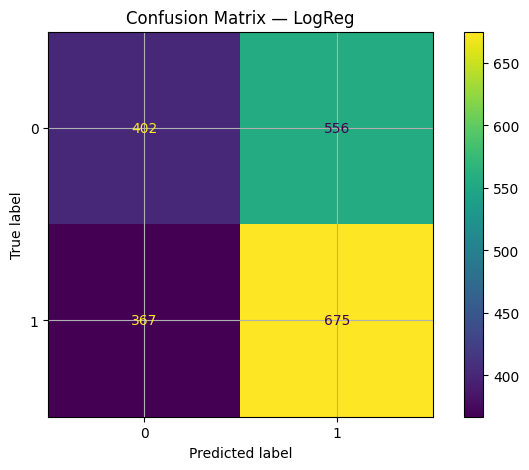

In [53]:

# Pick best by F1 then AUC
res_df = pd.DataFrame(results_cls).T
best_name = res_df.sort_values(by=["f1","roc_auc"], ascending=False).index[0]
best_cls_pipe = Pipeline([("prep", preprocess_cls), ("mdl", models_cls[best_name])])
best_cls_pipe.fit(X_train, y_train)

# Persist
joblib.dump(best_cls_pipe, MODELS / "supply_chain_on_time_model.pkl")
print("Saved:", MODELS / "supply_chain_on_time_model.pkl")

# Confusion matrix
y_pred = best_cls_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix — {best_name}")
plt.show()


## 4) Regression: Predict Shipment Cost

In [54]:

X_reg = df.drop(columns=["ShipmentCost", "OnTimeDelivery"])
y_reg = df["ShipmentCost"]

preprocess_reg = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

models_reg = {
    "Linear": LinearRegression(),
    "TreeReg": DecisionTreeRegressor(max_depth=10, random_state=RANDOM_SEED),
    "RFReg": RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED)
}

Xtr, Xte, ytr, yte = train_test_split(X_reg, y_reg, test_size=0.2, random_state=RANDOM_SEED)

res_reg = {}
for name, mdl in models_reg.items():
    pipe = Pipeline([("prep", preprocess_reg), ("mdl", mdl)])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    mse = mean_squared_error(yte, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yte, pred)
    res_reg[name] = dict(RMSE=rmse, R2=r2)

pd.DataFrame(res_reg).T


,RMSE,R2
Linear,198.629829,0.920494
TreeReg,128.109648,0.966927
RFReg,101.563417,0.979213


In [55]:

# Pick best by RMSE (lower is better), then R2
reg_df = pd.DataFrame(res_reg).T
best_reg = reg_df.sort_values(by=["RMSE","R2"], ascending=[True, False]).index[0]
best_reg_pipe = Pipeline([("prep", preprocess_reg), ("mdl", models_reg[best_reg])]).fit(Xtr, ytr)
joblib.dump(best_reg_pipe, MODELS / "supply_chain_cost_model.pkl")
print("Saved:", MODELS / "supply_chain_cost_model.pkl")


Saved: C:\Users\dsurr\ibm_certs\SupplyChainHealthCare\proj_01\models\supply_chain_cost_model.pkl


## 5) Export Reliability Stats by Carrier & Lane (for Unified App)

In [56]:

# Aggregate on-time metrics by (Origin, Destination, Carrier)
grp = df.groupby(["Origin","Destination","Carrier"]).agg(
    count=("OnTimeDelivery","size"),
    on_time_rate=("OnTimeDelivery","mean"),
    avg_distance=("Distance","mean"),
    avg_cost=("ShipmentCost","mean")
).reset_index()

grp.to_csv(DATA / "carrier_lane_stats.csv", index=False)
grp.sort_values("on_time_rate", ascending=False).head(10)


,Origin,Destination,Carrier,count,on_time_rate,avg_distance,avg_cost
179,LAX,NYC,GammaFreight,37,0.810811,693.075676,1489.982432
140,HOU,MSP,AlphaTrans,32,0.781250,684.490625,1589.083437
176,LAX,NYC,AlphaTrans,49,0.775510,585.467347,1330.187347
104,DEN,MIA,AlphaTrans,39,0.769231,620.333333,1260.059231
208,PHX,NYC,AlphaTrans,29,0.724138,596.251724,1272.819655
191,LAX,SJC,GammaFreight,31,0.709677,626.722581,1293.101935
180,LAX,PHL,AlphaTrans,34,0.705882,562.652941,1140.097059
251,SEA,SFO,GammaFreight,37,0.702703,551.040541,1238.208378
152,HOU,SFO,AlphaTrans,37,0.702703,595.067568,1357.348378
136,HOU,MIA,AlphaTrans,42,0.690476,557.945238,1271.223810
